In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
from sklearn.utils import class_weight 
import matplotlib
import matplotlib.pyplot as plt

# own code
import sys
sys.path.append("..") # relative path to module toolkit
from toolkit import getLabelsFromDir

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:22

In [2]:
input_size = (224, 224, 3)
num_classes = 44
n = 5
n = n * 6 + 2
mini_batch_size = 16 #article takes 256
epochs = 30#60 * 10 ** 4

steps_per_epoch = int(12525/mini_batch_size) + 1
validation_steps = int(3454/mini_batch_size) + 1

train_dir = "../../images/images_genus/train/"
val_dir = "../../images/images_genus/val/"

model_type = 'ResNet%dv1' % (n)

In [3]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


In [4]:
def resnet_v1(input_shape, depth, num_classes):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [5]:


model = resnet_v1(input_shape=input_size, depth=n, num_classes=num_classes)

In [6]:
model.compile(loss='categorical_crossentropy',
              #optimizer=SGD(lr=0.1,momentum=0.9, decay=0.0001),
              optimizer=SGD(lr=0.0001),
              metrics=['accuracy'])

model.summary()
print(model_type)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
save_dir = os.path.join(os.getcwd(), 'saved_models_weighted')
model_name = 'resnetOrig_%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown=0,
                               patience=0,
                               min_lr=0.5e-6)

early_stop = EarlyStopping(patience=2)

callbacks = [checkpoint, lr_reducer, early_stop]

In [8]:
assert(getLabelsFromDir(train_dir) == getLabelsFromDir(val_dir))
labels = getLabelsFromDir(train_dir)

train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

#no augmentation other than rescaling pixels

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=mini_batch_size,
                                                    color_mode='rgb',
                                                    target_size=input_size[:2] )
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=mini_batch_size,
                                                    color_mode='rgb',
                                                    target_size=input_size[:2] )


Found 12525 images belonging to 44 classes.
Found 3454 images belonging to 44 classes.


In [9]:
W = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

array([ 8.13311688, 14.98205742, 10.1663961 ,  9.81583072,  1.88515954,
        3.3887987 ,  5.17561983,  1.64542827,  9.18255132,  1.9104637 ,
        4.66654247,  4.12549407,  2.37215909,  0.57506887,  1.53869779,
        1.83651026,  2.10858586,  0.68427666, 10.1663961 ,  1.37516469,
        2.00464149,  5.5815508 ,  5.5815508 ,  0.2451844 ,  3.2347624 ,
        0.08777647,  3.95359848,  2.20665962,  0.68758235,  2.00464149,
        1.48259943,  0.38941052,  3.55823864,  1.44497   ,  1.21131528,
       11.38636364, 14.98205742,  1.20618259,  0.17593269,  0.6574113 ,
        1.01302168,  1.45979021, 17.79119318,  1.9104637 ])

In [10]:
# Fit the model on the batches generated by generator.
history = model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    #verbose=1,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=callbacks,
                    class_weight=W)

Epoch 1/30
783/783 [==============================] - 313s 400ms/step - loss: 3.3303 - acc: 0.2766 - val_loss: 2.9419 - val_acc: 0.3376

Epoch 00001: val_acc improved from -inf to 0.33758, saving model to /home/herri/Documents/BachelorProject/models/resnetOriginal/saved_models_weighted/resnetOrig_ResNet32v1_model.001.h5
Epoch 2/30
783/783 [==============================] - 310s 396ms/step - loss: 2.7606 - acc: 0.3741 - val_loss: 2.6129 - val_acc: 0.4027

Epoch 00002: val_acc improved from 0.33758 to 0.40272, saving model to /home/herri/Documents/BachelorProject/models/resnetOriginal/saved_models_weighted/resnetOrig_ResNet32v1_model.002.h5
Epoch 3/30
783/783 [==============================] - 310s 396ms/step - loss: 2.4955 - acc: 0.4294 - val_loss: 2.4035 - val_acc: 0.4505

Epoch 00003: val_acc improved from 0.40272 to 0.45049, saving model to /home/herri/Documents/BachelorProject/models/resnetOriginal/saved_models_weighted/resnetOrig_ResNet32v1_model.003.h5
Epoch 4/30
783/783 [========

783/783 [==============================] - 310s 395ms/step - loss: 0.9783 - acc: 0.7755 - val_loss: 1.0478 - val_acc: 0.7481

Epoch 00028: val_acc improved from 0.74059 to 0.74812, saving model to /home/herri/Documents/BachelorProject/models/resnetOriginal/saved_models_weighted/resnetOrig_ResNet32v1_model.028.h5
Epoch 29/30
783/783 [==============================] - 311s 397ms/step - loss: 0.9630 - acc: 0.7782 - val_loss: 1.0438 - val_acc: 0.7481

Epoch 00029: val_acc did not improve from 0.74812
Epoch 30/30
783/783 [==============================] - 311s 398ms/step - loss: 0.9478 - acc: 0.7855 - val_loss: 1.0131 - val_acc: 0.7594

Epoch 00030: val_acc improved from 0.74812 to 0.75941, saving model to /home/herri/Documents/BachelorProject/models/resnetOriginal/saved_models_weighted/resnetOrig_ResNet32v1_model.030.h5


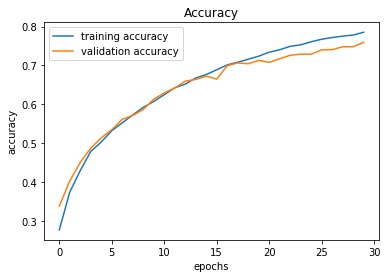

In [11]:
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()